This project is the replication of the inspiring project "PubMed 200k RCT" (https://arxiv.org/pdf/1710.06071.pdf)

The purpose of this project is to build a NLP model to make the abstract of medical research paper faster and easier to read.

The dataset utilized in this project is available in: https://arxiv.org/abs/1710.06071 and can be downloaded from the author's GitHub - Mr. Franck Dernoncourt (https://github.com/Franck-Dernoncourt/pubmed-rct)

## I. IMPORT LIBRARIES AND ESSENTIAL FUNCTIONS

In [ ]:
# Mount Google drive locally
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

!pip install --quiet tensorflow-text
!pip install tensorflow_text
import tensorflow_text as text

import os

# Install Transformers library 
!pip install transformers
!pip install bert-for-tf2

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('dark_background')

     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 29.5 MB/s 
     |████████████████████████████████| 3.3 MB 36.8 MB/s 
     |████████████████████████████████| 596 kB 47.7 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 41 kB 152 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=6dfd173501d06690123467acd6338f4ef2d98059084e95354c2e51f5abe98351
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=4b2f97aa59f201265716b52b4acc2d02316c28c9317c698c8c95474fbe914eba
  Stored in directory

## III. PREPARE DATA AND EMBEDDING LAYERS

### 1. LOAD DATASETS

Data preprocessing and EDA details: https://colab.research.google.com/drive/1rN-BfkA5Vc5nMToka_Pyr1q1DtxlXxki#scrollTo=cdft12E7M0Kf

In [ ]:
train_df = pd.read_pickle('/content/gdrive/MyDrive/abstract_section_classification/data/train_dataset.pkl')
val_df = pd.read_pickle('/content/gdrive/MyDrive/abstract_section_classification/data/val_dataset.pkl')
test_df = pd.read_pickle('/content/gdrive/MyDrive/abstract_section_classification/data/test_dataset.pkl')

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((180040, 4), (30212, 4), (30135, 4))

### 2. LABEL DATA

In [ ]:
# Convert labels into numeric form
# Encode by OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # Encode and return an array because tensorflow is incompatible with sparse matrix
train_label_one_hot_encoded = one_hot_encoder.fit_transform(train_df['label'].to_numpy().reshape(-1, 1))
val_label_one_hot_encoded = one_hot_encoder.transform(val_df['label'].to_numpy().reshape(-1, 1))
test_label_one_hot_encoded = one_hot_encoder.transform(test_df['label'].to_numpy().reshape(-1, 1))

# Check with training data
train_label_one_hot_encoded

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Encode labels by LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encoded = label_encoder.fit_transform(train_df['label'].to_numpy())
val_label_encoded = label_encoder.transform(val_df['label'].to_numpy())
test_label_encoded = label_encoder.transform(test_df['label'].to_numpy())

# Check with training data
train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get the class of labels from LabelEncoder
number_of_classes = len(label_encoder.classes_)
name_of_label_class = label_encoder.classes_
print('Number of classes:', number_of_classes, '\n', name_of_label_class)

Number of classes: 5 
 ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


### 3. TOKEN-LEVEL DATA & TOKEN EMBEDDING LAYERS

In [ ]:
# Get lists of sentences only for all train, val, and test datasets
train_text_list = list(train_df['text'])
val_text_list = list(val_df['text'])
test_text_list = list(test_df['text'])

len(train_text_list), len(val_text_list), len(test_text_list)

(180040, 30212, 30135)

Feature Extraction with Pretrained Token Embeddings (Transfer Learning)
* BERT text embeddings: https://tfhub.dev/google/experts/bert/pubmed/2
* GloVe embeddings: https://nlp.stanford.edu/projects/glove/
* Tensorflow Hub Universal Sentence Encoder (v4): https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
module = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module, trainable=True)

In [ ]:
from bert import bert_tokenization

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
#
def build_bert_model(bert_encoder, max_len=128):
    input_token_id=layers.Input(shape=(max_len,), dtype=tf.int32)
    input_mask=layers.Input(shape=(max_len,), dtype=tf.int32)
    input_segment_id=layers.Input(shape=(max_len,), dtype=tf.int32)

    #bert_outputs = bert_encoder([input_token_id, input_mask, input_segment_id], training=False)

    _, sequence_output=bert_encoder([input_token_id, input_mask, input_segment_id]) # shape of sequence output [batch_size, max_len, 768]
    cls_token=sequence_output[:,0,:] # get the cls token embeddings
    output=layers.Dense(128, activation='relu')(cls_token)
    model=tf.keras.Model(inputs=[input_token_id, input_mask, input_segment_id], outputs=output)

    return model

In [ ]:
train_bert_inputs = bert_encode(train_text_list, tokenizer, max_len=128)
val_bert_inputs = bert_encode(val_text_list, tokenizer, max_len=128)
test_bert_inputs = bert_encode(test_text_list, tokenizer, max_len=128)

### 4. CHARACTER-LEVEL DATA (SUB-MODEL 2)

#### 3.1. Character-level Data Preparation

In [ ]:
# Create a character-level tokenizer
# Create a function to split sentences into characters
def split_characters(text):
    text_split_list = ' '.join(list(text))
    return text_split_list

In [ ]:
# Apply split_character function to train dataset
train_character_list = [split_characters(sentence) for sentence in train_text_list]
val_character_list = [split_characters(sentence) for sentence in val_text_list]
test_character_list = [split_characters(sentence) for sentence in test_text_list]

# Convert character_list into numpy array
train_character_list = np.array(train_character_list)
val_character_list = np.array(val_character_list)
test_character_list = np.array(test_character_list)

train_character_list[:5]

array(['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
       'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
       'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n 

#### 3.2. Character-level Embedding Layers

In [ ]:
# Get all keyboard characters
import string
keyboard_character = string.ascii_lowercase + string.digits + string.punctuation + ' ' + 'UNK' # Unknown characters
keyboard_character

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ UNK'

In [ ]:
# Create Token Vectorizer for Characters
from tensorflow.keras.layers import TextVectorization
number_of_character_tokens = len(keyboard_character)
character_vectorizer = TextVectorization(max_tokens=number_of_character_tokens,
                                         output_sequence_length=290)

In [ ]:
# Adapt character vectorizer to training character
character_vectorizer.adapt(train_character_list)

In [ ]:
# Check the number of words in the training vocabulary
rct_character_vocab = character_vectorizer.get_vocabulary()
print(f'Total number of characters: {len(rct_character_vocab)}')
print(f'The top 5 most common characters: {rct_character_vocab[:5]}')
print(f'The top 5 least common characters: {rct_character_vocab[-5:]}')

Total number of characters: 28
The top 5 most common characters: ['', '[UNK]', 'e', 't', 'i']
The top 5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
import random
select_train_characters = random.choice(train_character_list)
character_vectorized = character_vectorizer([select_train_characters])
print(f'Original character splitted sentence:\n {select_train_characters}\n')
print(f'Length of the original character splitted sentence: {len(select_train_characters)}\n')
print(f'Vectorized characters:\n {character_vectorized}\n')
print(f'Length of the vectorized characters: {len(character_vectorized[0])}')

Original character splitted sentence:
 e r y t h r o c y t e   s e d i m e n t a t i o n   r a t e   (   e s r   )   w a s   d e t e c t e d   u s i n g   w e s t e r g r e n   m e t h o d   .

Length of the original character splitted sentence: 153

Vectorized characters:
 [[ 2  8 19  3 13  8  7 11 19  3  2  9  2 10  4 15  2  6  3  5  3  4  7  6
   8  5  3  2  2  9  8 20  5  9 10  2  3  2 11  3  2 10 16  9  4  6 18 20
   2  9  3  2  8 18  8  2  6 15  2  3 13  7 10  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
# Creating character embedding layer
character_embedding_layer = layers.Embedding(input_dim=number_of_character_tokens,
                                             output_dim=25,
                                             mask_zero=True)

In [ ]:
# Test character embedding layer
print(f'Original character splitted sentence:\n {select_train_characters}\n')
select_character_embedded = character_embedding_layer(character_vectorized)
print(f'Embedded character:\n {select_character_embedded}\n')
print(f'Embedded character shape: {select_character_embedded.shape}\n')

Original character splitted sentence:
 e r y t h r o c y t e   s e d i m e n t a t i o n   r a t e   (   e s r   )   w a s   d e t e c t e d   u s i n g   w e s t e r g r e n   m e t h o d   .

Embedded character:
 [[[ 0.02501715  0.00274129  0.01693369 ...  0.00026101  0.03571183
    0.03645972]
  [-0.04019995  0.00349913  0.01097779 ...  0.02779149 -0.04338693
   -0.00153133]
  [ 0.01302106 -0.00516639  0.0490729  ...  0.00035653  0.0057217
   -0.00234292]
  ...
  [ 0.00388049 -0.02037104  0.01535119 ... -0.03048643 -0.02065626
    0.00480995]
  [ 0.00388049 -0.02037104  0.01535119 ... -0.03048643 -0.02065626
    0.00480995]
  [ 0.00388049 -0.02037104  0.01535119 ... -0.03048643 -0.02065626
    0.00480995]]]

Embedded character shape: (1, 290, 25)



### 5. LINE_NUMBER AND TOTAL_LINE DATA (SUB-MODEL 3)

In [ ]:
# Encode line number using OneHotEncoder
train_line_number_one_hot_encoder = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot_encoder = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot_encoder = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
print(train_line_number_one_hot_encoder.shape, val_line_number_one_hot_encoder.shape, test_line_number_one_hot_encoder.shape)

# Check the encoder with the first 5 rows
train_line_number_one_hot_encoder[:5]

(180040, 15) (30212, 15) (30135, 15)


<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Encode line number using OneHotEncoder
train_total_lines_one_hot_encoder = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot_encoder = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot_encoder = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
print(train_total_lines_one_hot_encoder.shape, val_total_lines_one_hot_encoder.shape, test_total_lines_one_hot_encoder.shape)

# Check the encoder with the first 5 rows
train_total_lines_one_hot_encoder[:5]

(180040, 20) (30212, 20) (30135, 20)


<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

### 6. TRAINING, VALIDATION AND TEST DATASETS

#### 4.1. Traning Dataset

In [ ]:
train_data = [train_bert_inputs, train_character_list, train_line_number_one_hot_encoder, train_total_lines_one_hot_encoder]
train_labels = train_label_one_hot_encoded

#### 4.2. Validation Dataset

In [ ]:
val_data = [val_bert_inputs, val_character_list, val_line_number_one_hot_encoder, val_total_lines_one_hot_encoder]
val_labels = val_label_one_hot_encoded

#### 4.3. Test Dataset

In [ ]:
test_data = [test_bert_inputs, test_character_list, test_line_number_one_hot_encoder, test_total_lines_one_hot_encoder]
test_labels = test_label_one_hot_encoded

## V. MODEL:

*This model is using: BERT token embeddings, Customized character embeddings, and Self-created feature embeddings for line_number and total_lines*

All the steps are listed as follows:
1. Create a token-level embedding model
2. Create a character-level model
3. Create a line_number feature model
4. Create a total_lines feature model
5. Combine 1 and 2 with a concatenate (layers.Concatenate)
6. Combine 3, 4, 5 with a concatenate (layers.Concatenate)
7. Build a series of output layers on the top of step 3
8. Create an output layer which receives token, character-level, positional sequences as inputs then returns sequence label probabilities as output
9. Combine the all inputs into a model

In [ ]:
# 1. Setup token model
token_model = build_bert_model(bert_layer, max_len=128)

# 2. Setup character model
character_inputs = layers.Input(shape=(1,), dtype='string', name='character_inputs')
character_vectorization = character_vectorizer(character_inputs)
character_embeddings = character_embedding_layer(character_vectorization)
character_bilstm = layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_outputs = Dense(128, activation='relu')(character_bilstm)
character_model = tf.keras.Model(inputs=character_inputs, outputs=character_outputs)

# 3. line_numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
line_number_outputs = Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_outputs)

# 4. total_lines model
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_line_input')
total_line_outputs = Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs, outputs=total_line_outputs)

# 5. Concatenate token and character inputs into model
token_character_embedding = layers.Concatenate(name='token_character_concatenate')([token_model.output, character_model.output])

token_character_embedding_dense = layers.Dense(256, activation='relu')(token_character_embedding)
dropout_layer = layers.Dropout(0.5)(token_character_embedding_dense)

# 6. Concatenate positional embedding into token and character embeddings (token_character_concatenate)
token_character_position_embedding = layers.Concatenate(name='token_character_position_embedding')([line_number_model.output, total_line_model.output, dropout_layer])

# 7. Create output layers
final_output = layers.Dense(number_of_classes, activation='softmax', name='final_output')(token_character_position_embedding)

# . Construct model with token and character inputs
model = tf.keras.Model(inputs=[token_model.input, character_model.input, line_number_model.input, total_line_model.input],
                       outputs=final_output,
                       name='token_character_position_model')

In [ ]:
# Summarize model
model.summary()

Model: "token_character_position_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
character_inputs (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
_____________________________________________________________________

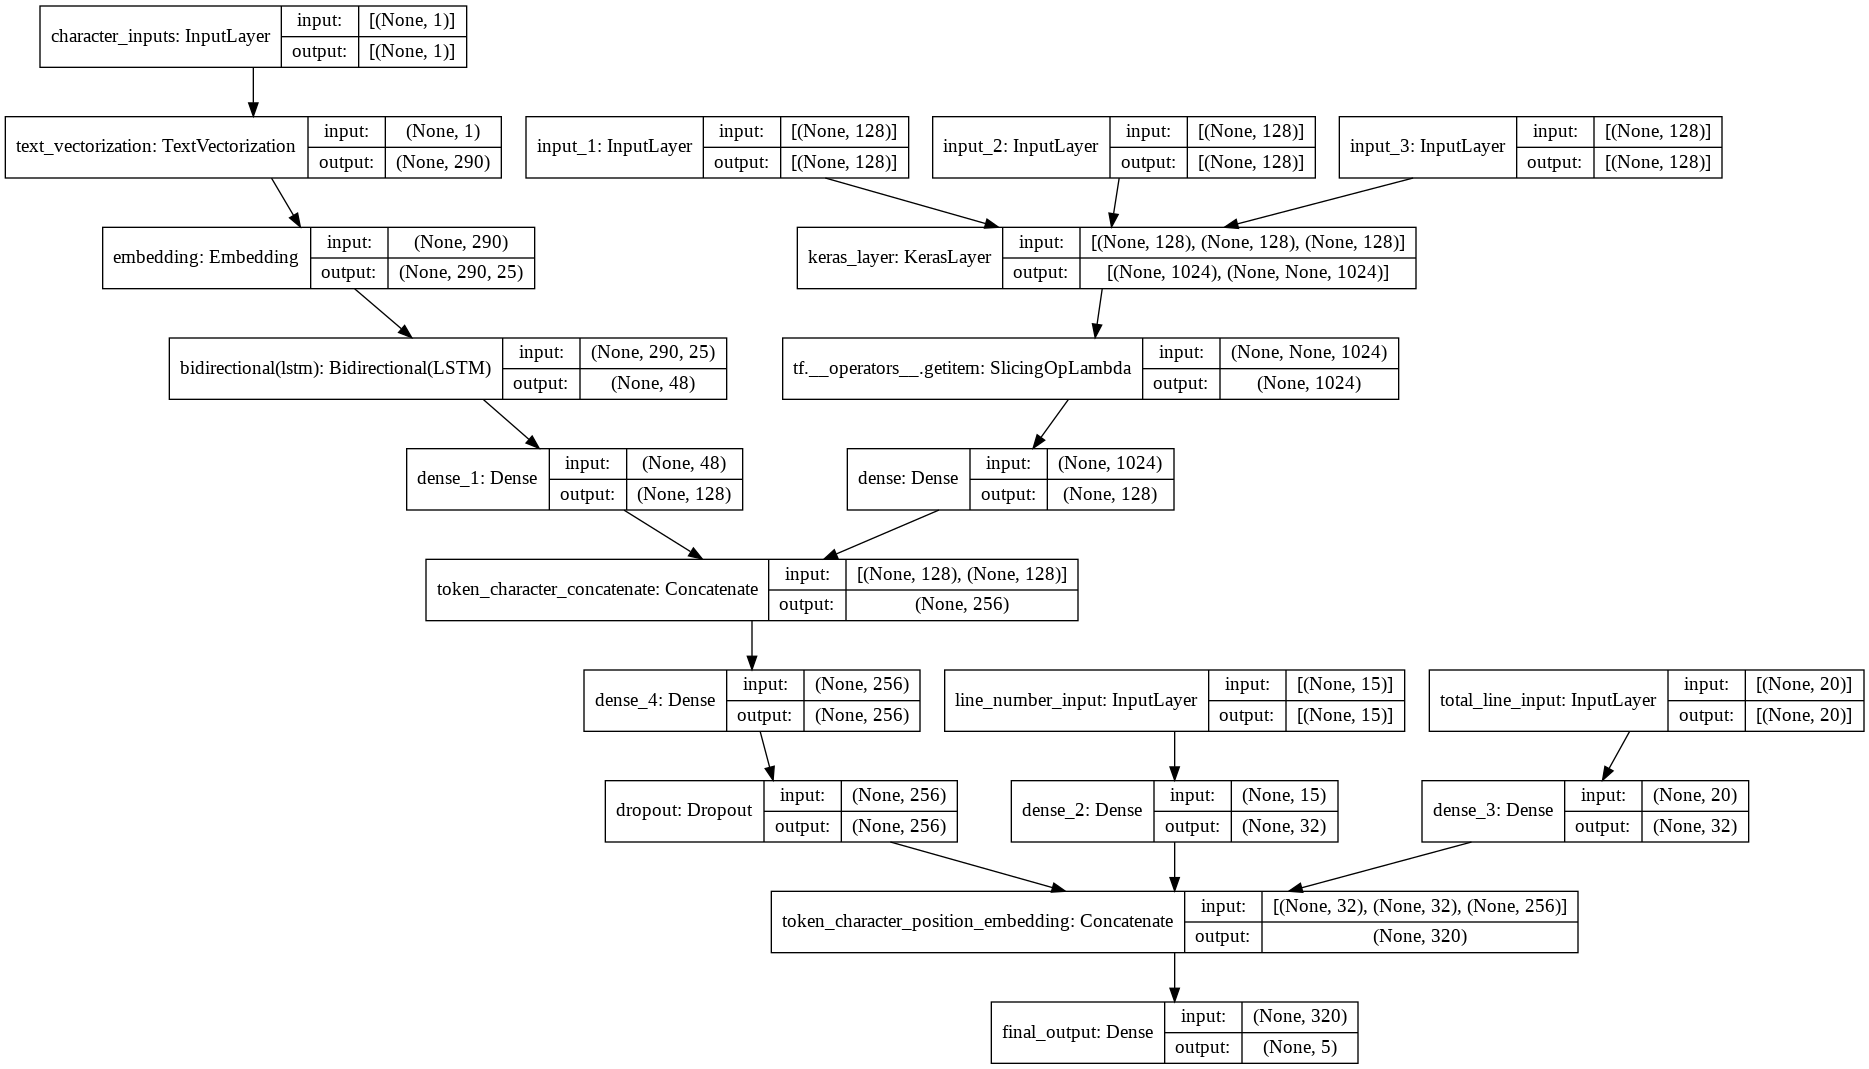

In [ ]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

*Notes: "None" stands for Batch_size*

Use tf.keras.losses.CategoricalCrossentropy with label smoothing to assign some amount of value from the highest prediction probability to other classes in case the model is too confident on only one class, therefore, to prevent overfitting.

In [ ]:
# Compile model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # help to prevent overfitting (requires one_hot_encoding data format)
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
# Create early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  verbose=2,
                                                  restore_best_weights=True)

file_path = '/content/gdrive/MyDrive/abstract_section_classification/epochs/{epoch:02d}-{val_accuracy:.2f}.h5'

# Create checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(file_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

# Create callbacks list
callbacks_list = [early_stopping, checkpoint]

In [ ]:
# Initialize epochs
init_epochs = 5

# Fit model
history_model_01 = model.fit(x=train_data,
                             y=train_labels,
                             validation_data=(val_data, val_labels),
                             epochs=init_epochs,
                             batch_size=16,
                             verbose=1)

Epoch 1/5
11253/11253 [==============================] - 9703s 858ms/step - loss: 1.0727 - accuracy: 0.7307 - val_loss: 1.0085 - val_accuracy: 0.7811
Epoch 2/5
 2059/11253 [====>.........................] - ETA: 2:04:04 - loss: 1.0174 - accuracy: 0.7765

In [ ]:
# Save model
model.save('/content/gdrive/MyDrive/abstract_section_classification/model/Abstract_Section_Classification_01')

In [ ]:
init_epochs = 5
fine_tune_epochs = 5
total_epochs = init_epochs + fine_tune_epochs

history_02 = model.fit(x=train_data,
                       y=train_labels,
                       validation_data=(val_data, val_labels),
                       epochs=total_epochs,
                       initial_epoch=init_epochs,
                       callbacks=callbacks_list,
                       batch_size=16,
                       verbose=1)

In [ ]:
# Save model
model.save('/content/gdrive/MyDrive/abstract_section_classification/model/Abstract_Section_Classification_02')

In [ ]:
init_epochs = 10
fine_tune_epochs = 5
total_epochs = init_epochs + fine_tune_epochs

history_02 = model.fit(x=train_data,
                       y=train_labels,
                       validation_data=(val_data, val_labels),
                       epochs=total_epochs,
                       initial_epoch=init_epochs,
                       callbacks=callbacks_list,
                       batch_size=16,
                       verbose=1)

In [ ]:
# Save model
model.save('/content/gdrive/MyDrive/abstract_section_classification/model/Abstract_Section_Classification_03')

In [ ]:
init_epochs = 15
fine_tune_epochs = 5
total_epochs = init_epochs + fine_tune_epochs

history_02 = model.fit(x=train_data,
                       y=train_labels,
                       validation_data=(val_data, val_labels),
                       epochs=total_epochs,
                       initial_epoch=init_epochs,
                       callbacks=callbacks_list,
                       batch_size=16,
                       verbose=1)

In [ ]:
# Save model
model.save('/content/gdrive/MyDrive/abstract_section_classification/model/Abstract_Section_Classification_04')

In [ ]:
init_epochs = 20
fine_tune_epochs = 5
total_epochs = init_epochs + fine_tune_epochs

history_02 = model.fit(x=train_data,
                       y=train_labels,
                       validation_data=(val_data, val_labels),
                       epochs=total_epochs,
                       initial_epoch=init_epochs,
                       callbacks=callbacks_list,
                       batch_size=16,
                       verbose=1)

In [ ]:
# Save model
model.save('/content/gdrive/MyDrive/abstract_section_classification/model/Abstract_Section_Classification_05')

In [ ]:
# Evaluate model
model.evaluate(train_data)

In [ ]:
# Use model to predict validation dataset
model_pred_proba = model.predict(val_data) # token_character_val_dataset is required to have the same format as the training dataset
model_pred_proba

In [ ]:
# Convert probability predictions into labels
model_preds = tf.argmax(model_pred_proba, axis=1)
model_preds

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Evaluate model prediction results
model_prediction_results = calculate_results(y_true=val_labels,
                                             y_pred=model_preds)

model_prediction_results

In [ ]:
# Write a function to check the Confusion Matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title="Confusion Matrix",
            xlabel="Predicted label",
            ylabel="True label",
            xticks=np.arange(n_classes), # create enough axis slots for each class
            yticks=np.arange(n_classes), 
            xticklabels=labels, # axes will labeled with class names (if they exist) or ints
            yticklabels=labels)
    
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
        plt.text(j, i, f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)

    #   # Save the figure to the current working directory
    #   if savefig:
    #     fig.savefig("confusion_matrix.png")

In [ ]:
confusion_matrix(y_true=val_labels,
                 y_pred=model_preds)

### Save and Load Model

In [ ]:
# Save model
model.save('/content/gdrive/MyDrive/abstract_section_classification/model/Abstract_Section_Classification')

In [ ]:
# Load model
loaded_model = tf.keras.models.load_model('/content/gdrive/MyDrive/abstract_section_classification/model/Abstract_Section_Classification')

### DISCOVER MORE:

1. Training, Validation, and Testing data preparation: https://colab.research.google.com/drive/1rN-BfkA5Vc5nMToka_Pyr1q1DtxlXxki#scrollTo=FhIyNphGtFAY

2. Model creation and training: https://colab.research.google.com/drive/1ZrEdJBmeU0FDtNN5F_s0eU6yqvAEIPMt#scrollTo=d0etEZ_Mpqw1&uniqifier=1

3. Demo data preprocessing and model prediction
https://colab.research.google.com/drive/1l3fQn91sOx7KbsLBiIPls_Aaw9CvAkFY#scrollTo=vS0raMb7tNqR